# Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/TESI/images

Mounted at /gdrive
/gdrive/My Drive/TESI/images


In [ ]:
# import modules
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

In [ ]:
from jax import config
config.update("jax_enable_x64", True)

In [ ]:
import os
from PIL import Image


def load_dataset(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('L')
                img_array = jnp.array(img)
                if img_array.shape[0] == 240:
                  img_array = jnp.transpose(img_array)
                images.append(img_array)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
    return jnp.array(images)

In [ ]:
dataset_val = load_dataset("./val/LR")
print(f"Loaded {len(dataset_val)} images")

Loaded 20 images


In [ ]:
dataset_train = load_dataset("./train/LR")
print(f"Loaded {len(dataset_train)} images")

Loaded 80 images


In [ ]:
dataset_val.shape, dataset_train.shape

((20, 160, 240), (80, 160, 240))

In [ ]:
def normalize_dataset(dataset):
  mean = jnp.mean(dataset)
  var = jnp.var(dataset)
  dataset = (dataset - mean) / var
  return dataset

# Normalize the datasets
normalized_dataset_val = normalize_dataset(dataset_val)
normalized_dataset_train = normalize_dataset(dataset_train)

print("Normalized Validation Dataset Shape:", normalized_dataset_val.shape)
print("Normalized Training Dataset Shape:", normalized_dataset_train.shape)


Normalized Validation Dataset Shape: (20, 160, 240)
Normalized Training Dataset Shape: (80, 160, 240)


In [ ]:
def batch_dataset(dataset, batch_size):
  n_samples = dataset.shape[0]
  n_batches = (n_samples + batch_size - 1) // batch_size  # Ensure all samples are included in batches
  batches = []
  for i in range(n_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, n_samples)
    batches.append(dataset[start:end])
  return batches

batch_size = 10
batched_train_data = batch_dataset(normalized_dataset_train, batch_size)

# Architecture

In [ ]:
def param_num(sizes):
  num = 0
  for pair in zip(sizes[:-1], sizes[1:]):
    num += pair[0] * pair[1] + pair[1]
  return num

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale = 2):
  w_key, b_key = random.split(key)
  return scale * random.uniform(w_key,(n, m), minval= -jnp.sqrt(6/(n+m)), maxval= jnp.sqrt(6/(n+m))), jnp.zeros((n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes_target = [2, 16, 32, 16, 1]
layer_sizes_hypernetwork = [dataset_val.shape[1] * dataset_val.shape[2], 16, 16, 16, param_num(layer_sizes_target)]
params_hyper = init_network_params(layer_sizes_hypernetwork, random.key(0))

In [ ]:
def layer_norm(x, epsilon=1e-5):
    mean = jnp.mean(x, axis=-1, keepdims=True)
    variance = jnp.var(x, axis=-1, keepdims=True)
    normalized = (x - mean) / jnp.sqrt(variance + epsilon)
    return normalized

In [ ]:
@jit
def target(input, params):
  activations = input
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [ ]:
batched_target = vmap(vmap(target, in_axes=(0, None)), in_axes=(0, None))
batched_target = vmap(batched_target, in_axes=(None, 0))

In [ ]:
@jit
def relu(x):
  return jnp.maximum(0, x)

In [ ]:
@jit
def hypernetwork(input, params):
  activations = input
  i = 1
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
    if i == 3:
      activations = layer_norm(activations)
    i += 1
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [ ]:
batched_hypernetwork = vmap(hypernetwork, in_axes=(0, None))

In [ ]:
def reshape_params(params, sizes):
  reshaped_params = []
  dividers = [(0,0)]
  for pair in zip(sizes[:-1], sizes[1:]):
    dividers.append((dividers[-1][1]+pair[0] * pair[1], dividers[-1][1]+pair[0] * pair[1]+ pair[1]))
  for i, divider in enumerate(dividers[1:]):
    w = params[dividers[i][1]:divider[0]]
    w = jnp.reshape(w, (sizes[i+1], sizes[i]))
    b = params[divider[0]:divider[1]]
    reshaped_params.append((w,b))
  return reshaped_params

In [ ]:
batched_reshape_params = vmap(reshape_params, in_axes=(0, None))

In [ ]:
y = jnp.linspace(0, 1, dataset_val.shape[1])
x = jnp.linspace(0, 1, dataset_val.shape[2])
X, Y = jnp.meshgrid(x, y)
coords = jnp.stack((X, Y), axis=-1)

In [ ]:
coords.shape

(160, 240, 2)

In [ ]:
def MSE(params_hyper, dataset):
  params = batched_hypernetwork(dataset.reshape(dataset.shape[0], -1), params_hyper)
  params = batched_reshape_params(params, layer_sizes_target)
  out_fields = batched_target(coords, params)
  out_fields = jnp.squeeze(out_fields, axis=3)
  error = out_fields - dataset
  return jnp.mean(jnp.square(error))

# Auxiliary functions

In [ ]:
@jit
def get_gradient(params, dataset):
  grad_params = grad(MSE)(params, dataset)
  return grad_params

In [ ]:
@jit
def update_params(params, grad_params, step_size):
  new_params = [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grad_params)]
  return new_params

#Training

In [ ]:
def generate_horizontal_gradient(width, height):
  """Generates a horizontal gradient image as a NumPy array.

  Args:
    width: The width of the image.
    height: The height of the image.

  Returns:
    A NumPy array representing the horizontal gradient image.
  """
  gradient_image = jnp.zeros((height, width), dtype=jnp.float64)

  for x in range(width):
    gradient_image = gradient_image.at[:, x].set(jnp.sin(2*jnp.pi * x / width))
  return gradient_image

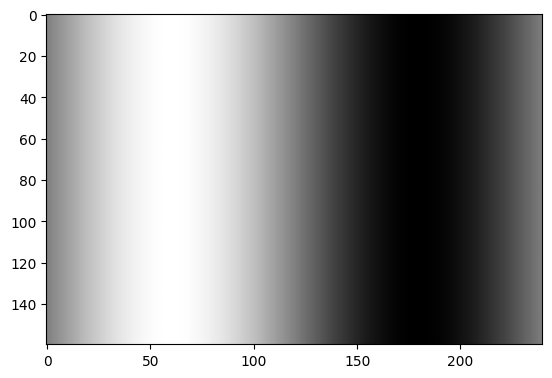

In [ ]:
width = 240
height = 160
horizontal_gradient = generate_horizontal_gradient(width, height)

plt.imshow(horizontal_gradient, cmap='gray')
plt.show()

In [ ]:
horizontal_gradient = jnp.expand_dims(horizontal_gradient, axis=0)

In [ ]:
jnp.mean(horizontal_gradient), jnp.std(horizontal_gradient)

(Array(-1.18423789e-17, dtype=float64), Array(0.70710678, dtype=float64))

In [ ]:
horizontal_gradient = normalize_dataset(horizontal_gradient)

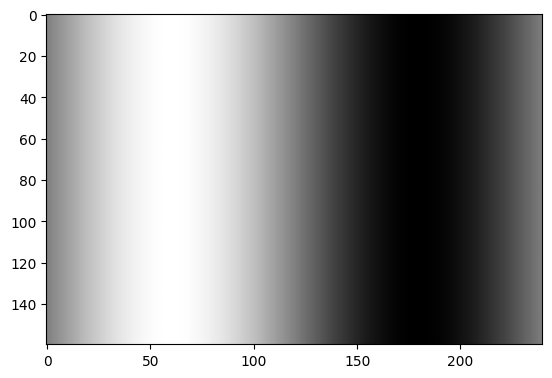

In [ ]:
plt.imshow(horizontal_gradient[0], cmap='gray')
plt.show()

In [ ]:
horizontal_gradient_dataset = jnp.repeat(horizontal_gradient, 10, axis=0)
horizontal_gradient_dataset.shape

(10, 160, 240)

In [ ]:
import time

step_size = 1e-2
num_epochs = 700

gradient_history = []
parameters = params_hyper
start_time = time.time()
for epoch in range(num_epochs):
  gradients = get_gradient(parameters, horizontal_gradient_dataset)
  parameters = update_params(parameters, gradients, step_size)
  gradient_history.append(jnp.mean(gradients[1][0]))
  if epoch % 10 == 0:
    step_size = step_size * 0.95
    epoch_time = time.time() - start_time
    print("Epoch {} in {:0.2f} sec, MSE = {:0.5E}".format(epoch, epoch_time, MSE(parameters, horizontal_gradient_dataset)))

epoch_time = time.time() - start_time

Epoch 0 in 0.00 sec, MSE = 2.54113E+00
Epoch 10 in 0.24 sec, MSE = 1.31043E+00
Epoch 20 in 1.08 sec, MSE = 1.00145E+00
Epoch 30 in 1.89 sec, MSE = 1.66425E+00
Epoch 40 in 2.71 sec, MSE = 1.63152E+00
Epoch 50 in 3.53 sec, MSE = 6.78474E-01
Epoch 60 in 4.34 sec, MSE = 2.64753E+00
Epoch 70 in 5.16 sec, MSE = 7.06430E-01
Epoch 80 in 5.97 sec, MSE = 6.42903E-01
Epoch 90 in 6.79 sec, MSE = 5.37629E-01
Epoch 100 in 7.61 sec, MSE = 4.43643E-01
Epoch 110 in 8.42 sec, MSE = 3.42523E-01
Epoch 120 in 9.24 sec, MSE = 2.66323E-01
Epoch 130 in 10.06 sec, MSE = 2.17990E-01
Epoch 140 in 10.87 sec, MSE = 1.92544E-01
Epoch 150 in 11.69 sec, MSE = 1.78911E-01
Epoch 160 in 12.50 sec, MSE = 1.67491E-01
Epoch 170 in 13.33 sec, MSE = 1.57176E-01
Epoch 180 in 14.14 sec, MSE = 1.46194E-01
Epoch 190 in 14.96 sec, MSE = 1.37891E-01
Epoch 200 in 15.78 sec, MSE = 1.33115E-01
Epoch 210 in 16.60 sec, MSE = 1.30067E-01
Epoch 220 in 17.43 sec, MSE = 1.27552E-01
Epoch 230 in 18.25 sec, MSE = 1.24983E-01
Epoch 240 in 19.

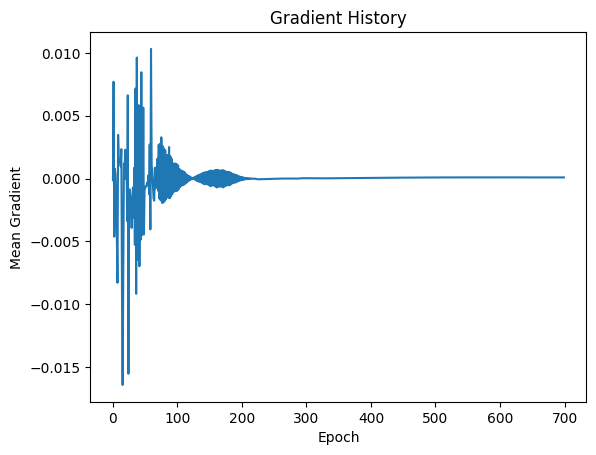

In [ ]:
# prompt: plot gradient_history

import matplotlib.pyplot as plt
plt.plot(gradient_history)
plt.xlabel("Epoch")
plt.ylabel("Mean Gradient")
plt.title("Gradient History")
plt.show()


In [ ]:
test = batched_hypernetwork(horizontal_gradient.reshape(horizontal_gradient.shape[0], -1), parameters)
test = batched_reshape_params(test, layer_sizes_target)
images = batched_target(coords, test)

In [ ]:
jnp.max(test[0][0]), jnp.min(test[0][0])

(Array(0.88772234, dtype=float64), Array(-1.87004585, dtype=float64))

In [ ]:
import time

step_size = 1e-2
num_epochs = 500


start_time = time.time()

for epoch in range(num_epochs):
  for i, batch in enumerate(batched_train_data):
    gradients = get_gradient(params_hyper, batch)
    params_hyper = update_params(params_hyper, gradients, step_size)
    if epoch % 10 == 0 and i == len(batched_train_data) - 1:
      step_size = step_size * 0.95
      epoch_time = time.time() - start_time
      print("Epoch {} in {:0.2f} sec, MSE = {:0.5E}".format(epoch, epoch_time, MSE(params_hyper, batch)))

epoch_time = time.time() - start_time

Epoch 0 in 1.27 sec, MSE = 8.31894E-03
Epoch 10 in 7.29 sec, MSE = 1.39431E-03
Epoch 20 in 13.74 sec, MSE = 8.43502E-04
Epoch 30 in 20.19 sec, MSE = 6.30244E-04
Epoch 40 in 26.65 sec, MSE = 5.25235E-04
Epoch 50 in 33.09 sec, MSE = 4.63937E-04
Epoch 60 in 39.54 sec, MSE = 4.24237E-04
Epoch 70 in 45.99 sec, MSE = 3.98255E-04
Epoch 80 in 52.43 sec, MSE = 3.79451E-04
Epoch 90 in 58.87 sec, MSE = 3.64975E-04
Epoch 100 in 65.32 sec, MSE = 3.52907E-04
Epoch 110 in 71.76 sec, MSE = 3.42769E-04
Epoch 120 in 78.21 sec, MSE = 3.34374E-04
Epoch 130 in 84.65 sec, MSE = 3.27538E-04
Epoch 140 in 91.10 sec, MSE = 3.21827E-04
Epoch 150 in 97.54 sec, MSE = 3.16861E-04
Epoch 160 in 103.98 sec, MSE = 3.12542E-04
Epoch 170 in 110.43 sec, MSE = 3.08738E-04
Epoch 180 in 116.88 sec, MSE = 3.05319E-04
Epoch 190 in 123.32 sec, MSE = 3.02303E-04
Epoch 200 in 129.77 sec, MSE = 2.99566E-04
Epoch 210 in 136.21 sec, MSE = 2.97087E-04
Epoch 220 in 142.66 sec, MSE = 2.94807E-04
Epoch 230 in 149.10 sec, MSE = 2.92715E-

In [ ]:
params = batched_hypernetwork(normalized_dataset_val.reshape(normalized_dataset_val.shape[0], -1), params_hyper)
params = batched_reshape_params(params, layer_sizes_target)
images = batched_target(coords, params)

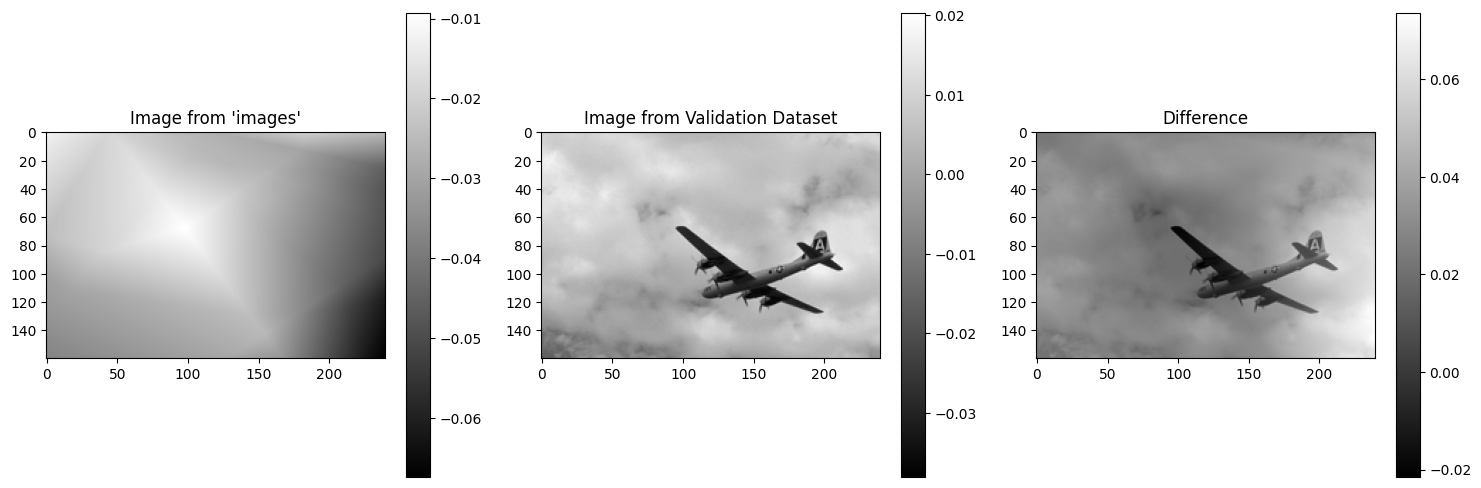

In [ ]:
# Select an image index for comparison (e.g., the first image)
image_index = 15

# Get the image from 'images'
image_to_compare = images[image_index]  # Adjust the access method based on your 'images' structure

# Get the corresponding image from the validation dataset
val_image = normalized_dataset_val[image_index]


# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(image_to_compare, cmap='gray')
axes[0].set_title("Image from 'images'")
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(val_image, cmap='gray')
axes[1].set_title("Image from Validation Dataset")
fig.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(val_image - jnp.squeeze(image_to_compare, axis=2), cmap='gray')
axes[2].set_title("Difference")
fig.colorbar(im3, ax=axes[2])


plt.tight_layout()

plt.show()


In [ ]:
jnp.std(image_to_compare), jnp.std(val_image)

(Array(1.37434032, dtype=float64), Array(1.41421356, dtype=float64))

In [ ]:
jnp.mean(image_to_compare), jnp.mean(val_image)

(Array(0.00312676, dtype=float64), Array(-1.18423789e-17, dtype=float64))

In [ ]:
gradients = get_gradient(params_hyper, horizontal_gradient_dataset)

In [ ]:
jnp.mean(gradients[0][0]), jnp.std(gradients[0][0])

(Array(-3.81639165e-19, dtype=float64), Array(0.16057312, dtype=float64))